In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas_gbq
#pip install pygraphviz
#import pygraphviz

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 7]

In [3]:
Deals = 5156758895250942611

In [4]:
'''
-4302568719576920909
-8104495516310030976
6264202757535876160   - only 2 stages
7372411383573846234 - too many stages
5179945650881144306
1008686653030123082 - nice

-799468424400376874

5156758895250942611 - very nice

'''

'\n-4302568719576920909\n-8104495516310030976\n6264202757535876160   - only 2 stages\n7372411383573846234 - too many stages\n5179945650881144306\n1008686653030123082 - nice\n\n-799468424400376874\n\n5156758895250942611 - very nice\n\n'

In [5]:
query = """
SELECT *
FROM `bcx-insights.telkom_customerexperience.orders_20190926_00_anon`
WHERE ACCOUNT_NO_ANON = {}
ORDER BY ORDER_CREATION_DATE, ACTION_CREATION_DATE, ORDER_ID_ANON
""".format(Deals)

In [6]:
query

'\nSELECT *\nFROM `bcx-insights.telkom_customerexperience.orders_20190926_00_anon`\nWHERE ACCOUNT_NO_ANON = 5156758895250942611\nORDER BY ORDER_CREATION_DATE, ACTION_CREATION_DATE, ORDER_ID_ANON\n'

In [7]:
orders_df = pd.read_gbq(query,
                project_id = 'bcx-insights',
                dialect = 'standard')

In [8]:
orders_df.tail(3)

,ORDER_STATUS_DESC,ORDER_CREATION_DATE,ACTION_STATUS_DESC,ACTION_TYPE,ACTION_TYPE_DESC,ACTION_CREATION_DATE,ORIGINAL_SALES_CHANNEL_DESC,CURRENT_SALES_CHANNEL_DESC,DEAL_DESC,PROV_DATE,CLOSE_DATE,OPEN_CLOSE_INDIC,SOURCE,ORDER_ID_ANON,ACCOUNT_NO_ANON,MSISDN_ANON,ORDER_ACTION_ID_ANON
30,Done,2019-02-23 23:27:25+00:00,Done,CE,Cease,2019-02-23 23:27:25+00:00,Call Center,Call Center,OptiCon Term Contract,2019-02-24 00:52:12+00:00,2019-02-24 02:05:21+00:00,C,F,-8577925185420972425,5156758895250942611,1756325591274441815,1086250673076155801
31,Done,2019-03-14 14:41:02+00:00,Done,MA,Modify Address,2019-03-14 00:00:00+00:00,Business Sales,Business Sales,OptiCon eMG Rental,2019-03-14 14:53:29+00:00,2019-03-14 14:53:36+00:00,C,F,-6837999586639569785,5156758895250942611,2710482545510557508,-1580293360493113035
32,Done,2019-03-14 14:59:16+00:00,Done,CE,Cease,2019-03-14 00:00:00+00:00,Business Sales,Business Sales,OptiCon eMG Rental,2019-03-14 23:59:59+00:00,2019-04-01 13:48:26+00:00,C,F,3400600444351100232,5156758895250942611,2710482545510557508,-8302224469961967151


In [9]:
len(orders_df)

33

In [10]:
orders_df = orders_df.drop_duplicates()

In [11]:
len(orders_df)

32

In [12]:
orders_df['MSISDN_ANON'] = orders_df['MSISDN_ANON'].astype(str)

In [13]:
orders_df['ORDER_ID_ANON'] = orders_df['ORDER_ID_ANON'].astype(str)

In [14]:
unique_col = 'combo'

In [15]:
orders_df[unique_col] = orders_df['MSISDN_ANON']+'_'+orders_df['ORDER_ID_ANON']

In [16]:
orders_df['stage'] = orders_df.groupby(unique_col).cumcount()+1

In [17]:
final_stage = orders_df[[unique_col,'stage']].groupby(unique_col).max()

In [18]:
final_stage.rename(columns={'stage':'final_stage'}, inplace=True)

In [19]:
final_stage.head()

,final_stage
combo,
-3886247749847034272_4834273730448523809,5
-4402699703705702704_3691872926838036956,1
-5402505769298551697_4834273730448523809,2
-8528343569355859671_4834273730448523809,2
-9164339062333871665_4834273730448523809,2


In [20]:
orders_df = pd.merge(orders_df, final_stage, on=unique_col, how='outer')

In [21]:
orders_df.head()

,ORDER_STATUS_DESC,ORDER_CREATION_DATE,ACTION_STATUS_DESC,ACTION_TYPE,ACTION_TYPE_DESC,ACTION_CREATION_DATE,ORIGINAL_SALES_CHANNEL_DESC,CURRENT_SALES_CHANNEL_DESC,DEAL_DESC,PROV_DATE,CLOSE_DATE,OPEN_CLOSE_INDIC,SOURCE,ORDER_ID_ANON,ACCOUNT_NO_ANON,MSISDN_ANON,ORDER_ACTION_ID_ANON,combo,stage,final_stage
0,Cancelled,2018-10-02 14:53:57+00:00,Cancelled,OT,Outdoor Transfer,2018-10-02 00:00:00+00:00,Consumer Sales,Consumer Sales,OptiCon eMG Rental,1950-01-01 00:00:00+00:00,1950-01-01 00:00:00+00:00,C,F,4834273730448523809,5156758895250942611,2710482545510557508,8289055179477593263,2710482545510557508_4834273730448523809,1,2
1,Done,2018-10-09 14:54:01+00:00,Done,OT,Outdoor Transfer,2018-10-02 00:00:00+00:00,Consumer Sales,Consumer Sales,OptiCon eMG Rental,2018-10-10 15:48:40+00:00,1950-01-01 00:00:00+00:00,C,F,4834273730448523809,5156758895250942611,2710482545510557508,6497314512581554733,2710482545510557508_4834273730448523809,2,2
2,Cancelled,2018-10-02 14:54:19+00:00,Cancelled,MV,Move Outdoor Other Exchange,2018-10-02 00:00:00+00:00,Consumer Sales,Consumer Sales,TBiz BB Capped Advanced,1950-01-01 00:00:00+00:00,1950-01-01 00:00:00+00:00,C,F,4834273730448523809,5156758895250942611,3842282672409691663,-2368358014249335978,3842282672409691663_4834273730448523809,1,4
3,Cancelled,2018-10-02 15:02:26+00:00,Cancelled,CM,Cease Part Of Move,2018-10-02 00:00:00+00:00,Consumer Sales,Consumer Sales,TBiz BB Capped Advanced,1950-01-01 00:00:00+00:00,1950-01-01 00:00:00+00:00,C,F,4834273730448523809,5156758895250942611,3842282672409691663,-3678093612542590147,3842282672409691663_4834273730448523809,2,4
4,Done,2018-10-09 14:54:01+00:00,Done,CM,Cease Part Of Move,2018-10-02 00:00:00+00:00,Consumer Sales,Consumer Sales,TBiz BB Capped Advanced,2018-10-09 14:56:35+00:00,1950-01-01 00:00:00+00:00,C,F,4834273730448523809,5156758895250942611,3842282672409691663,-6243901908868668088,3842282672409691663_4834273730448523809,3,4


In [22]:
orders_df['stage'] = orders_df['stage'].astype(str)

In [23]:
orders_df['ActionType_OrderStatus'] = orders_df['ACTION_TYPE_DESC'] +' * '+ orders_df['ORDER_STATUS_DESC'] 

In [24]:
type_status = list(orders_df['ActionType_OrderStatus'].unique())

In [25]:
orders_df['stage_ActionType_OrderStatus'] = orders_df['stage'] +') * '+ orders_df['ACTION_TYPE_DESC'] +' * '+ orders_df['ORDER_STATUS_DESC'] 

In [26]:
orders_df.tail(3)

,ORDER_STATUS_DESC,ORDER_CREATION_DATE,ACTION_STATUS_DESC,ACTION_TYPE,ACTION_TYPE_DESC,ACTION_CREATION_DATE,ORIGINAL_SALES_CHANNEL_DESC,CURRENT_SALES_CHANNEL_DESC,DEAL_DESC,PROV_DATE,...,SOURCE,ORDER_ID_ANON,ACCOUNT_NO_ANON,MSISDN_ANON,ORDER_ACTION_ID_ANON,combo,stage,final_stage,ActionType_OrderStatus,stage_ActionType_OrderStatus
29,Done,2019-02-23 23:27:25+00:00,Done,CE,Cease,2019-02-23 23:27:25+00:00,Call Center,Call Center,OptiCon Term Contract,2019-02-24 00:52:12+00:00,...,F,-8577925185420972425,5156758895250942611,1756325591274441815,1086250673076155801,1756325591274441815_-8577925185420972425,1,1,Cease * Done,1) * Cease * Done
30,Done,2019-03-14 14:41:02+00:00,Done,MA,Modify Address,2019-03-14 00:00:00+00:00,Business Sales,Business Sales,OptiCon eMG Rental,2019-03-14 14:53:29+00:00,...,F,-6837999586639569785,5156758895250942611,2710482545510557508,-1580293360493113035,2710482545510557508_-6837999586639569785,1,1,Modify Address * Done,1) * Modify Address * Done
31,Done,2019-03-14 14:59:16+00:00,Done,CE,Cease,2019-03-14 00:00:00+00:00,Business Sales,Business Sales,OptiCon eMG Rental,2019-03-14 23:59:59+00:00,...,F,3400600444351100232,5156758895250942611,2710482545510557508,-8302224469961967151,2710482545510557508_3400600444351100232,1,1,Cease * Done,1) * Cease * Done


In [27]:
#orders_df.groupby(unique_col)

In [28]:
customers = list(orders_df[unique_col].unique())

In [29]:
sorted_df = orders_df.sort_values('stage', ascending=False)
sorted_df.head(3)

,ORDER_STATUS_DESC,ORDER_CREATION_DATE,ACTION_STATUS_DESC,ACTION_TYPE,ACTION_TYPE_DESC,ACTION_CREATION_DATE,ORIGINAL_SALES_CHANNEL_DESC,CURRENT_SALES_CHANNEL_DESC,DEAL_DESC,PROV_DATE,...,SOURCE,ORDER_ID_ANON,ACCOUNT_NO_ANON,MSISDN_ANON,ORDER_ACTION_ID_ANON,combo,stage,final_stage,ActionType_OrderStatus,stage_ActionType_OrderStatus
14,Done,2018-10-09 14:54:01+00:00,Done,CM,Cease Part Of Move,2018-10-02 00:00:00+00:00,Consumer Sales,Consumer Sales,PSTN Junction Lines - Business,2018-10-09 14:56:39+00:00,...,F,4834273730448523809,5156758895250942611,-3886247749847034272,-2600238453859420086,-3886247749847034272_4834273730448523809,5,5,Cease Part Of Move * Done,5) * Cease Part Of Move * Done
5,Done,2018-10-09 14:54:01+00:00,Done,MV,Move Outdoor Other Exchange,2018-10-02 00:00:00+00:00,Consumer Sales,Consumer Sales,TBiz BB Capped Advanced,2018-10-09 14:56:37+00:00,...,F,4834273730448523809,5156758895250942611,3842282672409691663,-4311406567201441950,3842282672409691663_4834273730448523809,4,4,Move Outdoor Other Exchange * Done,4) * Move Outdoor Other Exchange * Done
9,Done,2018-10-09 14:54:01+00:00,Done,CM,Cease Part Of Move,2018-10-02 00:00:00+00:00,Consumer Sales,Consumer Sales,PSTN Junction Lines - Business,2018-10-09 14:56:50+00:00,...,F,4834273730448523809,5156758895250942611,4025061503049276343,-1094888384259571697,4025061503049276343_4834273730448523809,4,4,Cease Part Of Move * Done,4) * Cease Part Of Move * Done


In [30]:
len(orders_df[orders_df['stage']=='2'])

9

In [31]:
len(customers)

16

In [32]:
# Create a networkx graph object
J = nx.Graph()

In [33]:
J.clear()

In [34]:
max_stage=max(orders_df['stage'].astype(int))
max_stage

5

In [35]:
actions = list(orders_df['stage_ActionType_OrderStatus'].unique())

In [36]:
J.add_node(Deals,posi=(0.8,10), color = 'purple')

In [37]:
for i in range(1,max_stage+1):
  
  stage_actions = list(orders_df[orders_df['stage']==str(i)]['stage_ActionType_OrderStatus'].unique())
  #print(stage_actions)
  for k in range(len(stage_actions)):
    label = stage_actions[k]
    #print(label)
    label = label.split('* ',1)
    label = label[1]
    #print(label)
    height =  type_status.index(label) +1
    #print(height)
    J.add_node(stage_actions[k],posi=(i*1.25,height))
    #print(stage_actions[k])
    #print((i,k+1))

In [38]:
J.nodes(data = True)

NodeDataView({'2) * Cease Part Of Move * Cancelled': {'posi': (2.5, 4)}, '2) * Provide Part Of Move * Done': {'posi': (2.5, 8)}, '3) * Cease Part Of Move * Cancelled': {'posi': (3.75, 4)}, '1) * Soft Suspend * Done': {'posi': (1.25, 12)}, '1) * Outdoor Transfer * Cancelled': {'posi': (1.25, 1)}, '2) * Outdoor Transfer * Done': {'posi': (2.5, 2)}, '2) * Cease * Done': {'posi': (2.5, 11)}, '1) * Move Outdoor Other Exchange * Cancelled': {'posi': (1.25, 3)}, '4) * Move Outdoor Other Exchange * Done': {'posi': (5.0, 6)}, '1) * Modify Address * Done': {'posi': (1.25, 14)}, '3) * Move Outdoor Other Exchange * Done': {'posi': (3.75, 6)}, '1) * Provide Part Of Move * Cancelled': {'posi': (1.25, 7)}, '1) * Provide * Cancelled': {'posi': (1.25, 9)}, '1) * Cease * Done': {'posi': (1.25, 11)}, '1) * Resume from Suspension due to Collection * Done': {'posi': (1.25, 13)}, '4) * Cease Part Of Move * Done': {'posi': (5.0, 5)}, '5) * Cease Part Of Move * Done': {'posi': (6.25, 5)}, '3) * Cease Part Of 

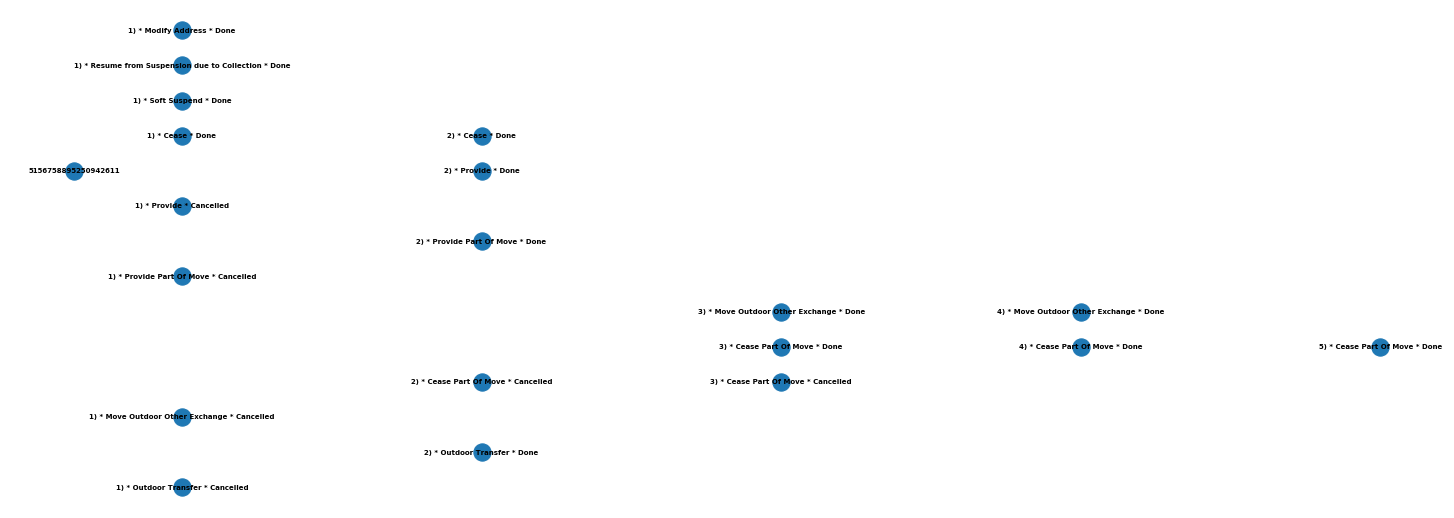

In [39]:
# Draw the resulting graph
pos = nx.get_node_attributes(J,'posi')
nx.draw(J, pos ,with_labels=True, font_weight='bold', font_size = 7)
plt.show()

In [40]:
# clear edges
J.remove_edges_from(list(J.edges()))

In [41]:
#create edges with data (count, days, ave_days)

date_col = orders_df.columns.get_loc('ORDER_CREATION_DATE')
kpi = 5

for c in customers:

    temp_df = orders_df[orders_df[unique_col] == c]
  
    for i in range(len(temp_df)-1):
        #print(i, c)
        if J.has_edge(temp_df.iloc[i, -1], temp_df.iloc[(i+1),-1]) == False:
            #print(temp_df.iloc[i, -1], temp_df.iloc[(i+1),-1])
            #print(temp_df.iloc[i,-4], temp_df.iloc[(i+1),-4])
            J.add_edge(temp_df.iloc[i, -1], temp_df.iloc[(i+1),-1])
            J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['count'] = 1
            difference = (temp_df.iloc[(i+1),date_col]-temp_df.iloc[i, date_col])
            J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['days'] = round(difference.total_seconds()/(60*60*24),1)
            J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['ave_days'] = round(J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['days']/ J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['count'],1)
            
            if J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['ave_days'] > kpi:
                J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['color'] = 'red'
            else:
                J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['color'] = 'green'

        else:
            current_count = J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['count']
            J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['count'] = current_count + 1

            current_days =  J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['days']
            difference = (temp_df.iloc[(i+1),date_col]-temp_df.iloc[i, date_col])
            J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['days'] = round(current_days + difference.total_seconds()/(60*60*24),1)

            J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['ave_days'] = round(J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['days']/ J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['count'],1)
            
            if J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['ave_days'] > kpi:
                J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['color'] = 'red'
            else:
                J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['color'] = 'green'


In [42]:
# add edge weight attribute

all_counts = []

#Iterate through the graph edges to gather all the weights
for (node1,node2,data) in J.edges(data=True):
    all_counts.append(data['count']) 

    
total_count = sum(all_counts)
max_count = max(all_counts)
min_count = min(all_counts)
ave_count = total_count/len(all_counts)
scale = 14

print(total_count)
print(max_count)
print(min_count)
print(ave_count)


if (max_count-min_count) == 0:
    for (node1,node2,data) in J.edges(data=True):
        J.edges[node1,node2]['weight'] = round(J.edges[node1,node2]['count'],1)

else:                                                
    for (node1,node2,data) in J.edges(data=True):
        J.edges[node1,node2]['weight'] = round(((J.edges[node1,node2]['count']-min_count)/(max_count-min_count))*scale+1,1)
    

16
3
1
1.3333333333333333


In [43]:
J.edges(data=True)

EdgeDataView([('2) * Cease Part Of Move * Cancelled', '3) * Cease Part Of Move * Done', {'ave_days': 7.0, 'count': 1, 'color': 'red', 'weight': 1.0, 'days': 7.0}), ('2) * Cease Part Of Move * Cancelled', '1) * Move Outdoor Other Exchange * Cancelled', {'ave_days': 0.0, 'count': 3, 'color': 'green', 'weight': 15.0, 'days': 0.0}), ('2) * Cease Part Of Move * Cancelled', '3) * Cease Part Of Move * Cancelled', {'ave_days': 6.0, 'count': 1, 'color': 'red', 'weight': 1.0, 'days': 6.0}), ('2) * Cease Part Of Move * Cancelled', '3) * Move Outdoor Other Exchange * Done', {'ave_days': 7.0, 'count': 1, 'color': 'red', 'weight': 1.0, 'days': 7.0}), ('3) * Cease Part Of Move * Cancelled', '4) * Move Outdoor Other Exchange * Done', {'ave_days': 1.0, 'count': 1, 'color': 'green', 'weight': 1.0, 'days': 1.0}), ('2) * Provide Part Of Move * Done', '1) * Provide Part Of Move * Cancelled', {'ave_days': 7.0, 'count': 3, 'color': 'red', 'weight': 15.0, 'days': 21.0}), ('1) * Provide * Cancelled', '2) * Pro

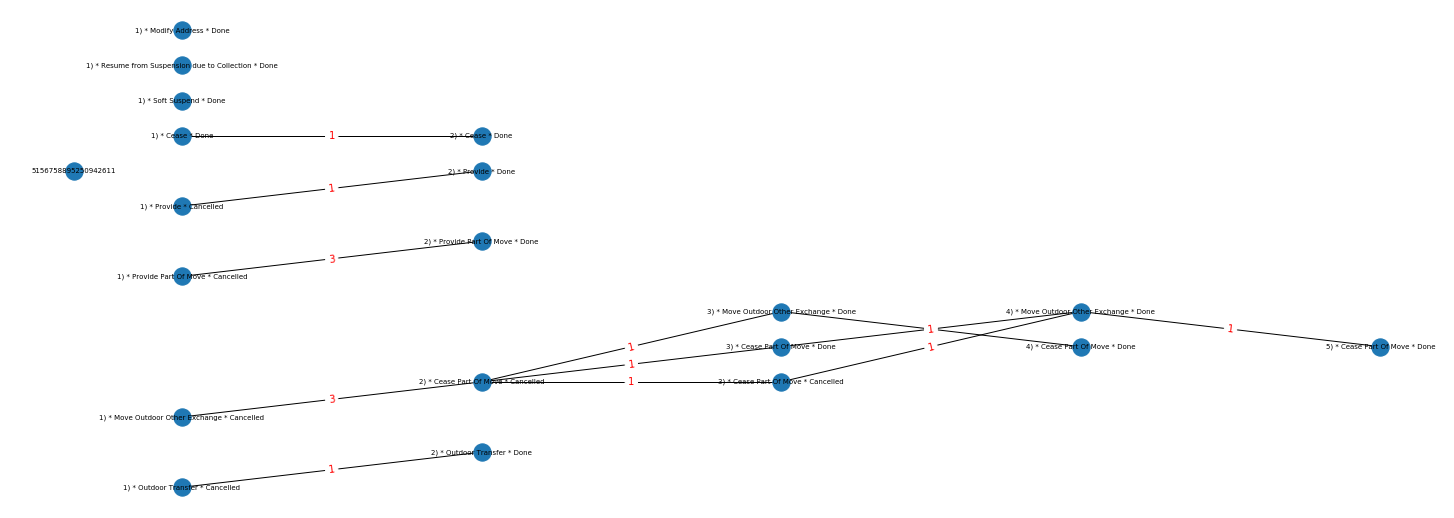

In [47]:
# Draw the resulting graph
#pos = nx.circular_layout(J)
pos = nx.get_node_attributes(J,'posi')
nx.draw(J,pos, with_labels=True, font_size = 7
        #, arrowstyle='->',arrowsize=15
       )

edge_labels = nx.get_edge_attributes(J, 'count')
nx.draw_networkx_edge_labels(J,pos,edge_labels=edge_labels,font_color='red')

plt.show()

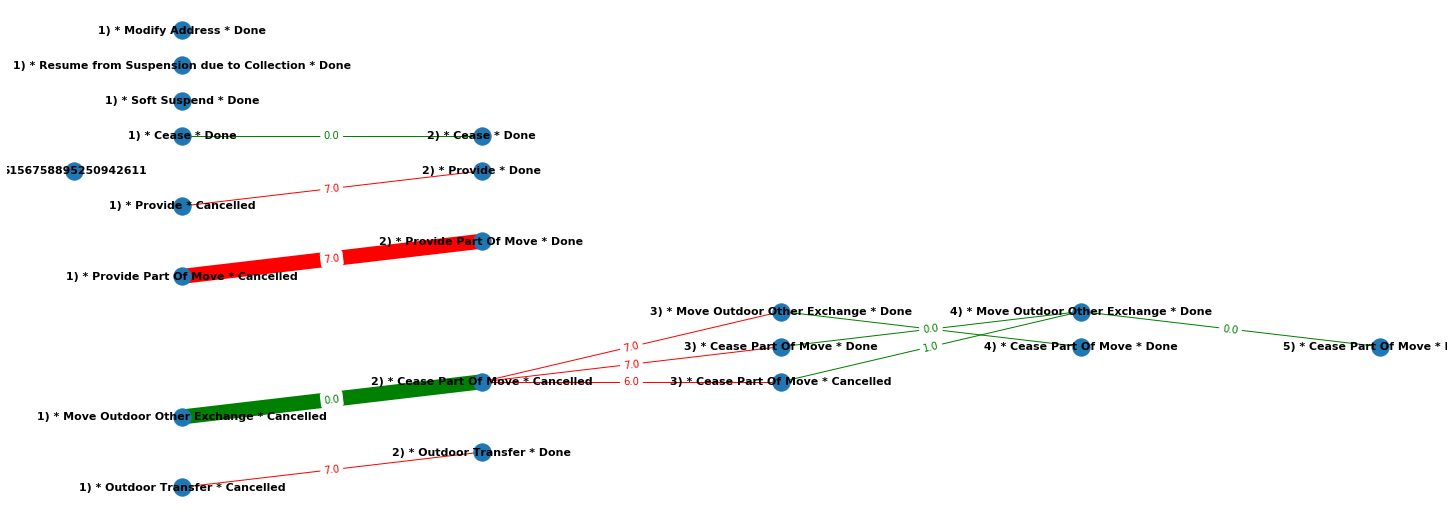

In [44]:
# Draw the resulting graph
#pos = nx.circular_layout(J)
pos = nx.get_node_attributes(J,'posi')
edges,colors = zip(*nx.get_edge_attributes(J,'color').items())
edges,width = zip(*nx.get_edge_attributes(J,'weight').items())


nx.draw(J,pos, with_labels=True, font_weight='bold', font_size = 11, edgelist=edges, edge_color=colors, width = width
       )

edge_labels  = nx.get_edge_attributes(J,'ave_days')
#label_color  = nx.get_edge_attributes(J,'color').values()

#print(pos)

for e in J.edges(data=True):
    #print(e)
    #print(e[0])
    #print(e[1])
    #print(e[2])
    #print(e[2]['color'])
    nx.draw_networkx_edge_labels(J,pos=pos,edge_labels={(e[0],e[1]):e[2]['ave_days']}, font_color = e[2]['color'])

plt.savefig('stage_transition_on_acc')
plt.show()

In [45]:
orders_df[orders_df['stage_ActionType_OrderStatus']=='2) * Cease Part Of Move * Cancelled']['MSISDN_ANON'].unique()

array(['3842282672409691663', '4025061503049276343',
       '-3886247749847034272'], dtype=object)

In [46]:
#orders_df[orders_df['ACCOUNT_NO_ANON']==5156758895250942611]